In [198]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Import and clean data

In [2]:
def perf(er, cov, weights):
    ER = er @ weights
    STD = np.sqrt(weights.T @ cov @ weights)
    SR = ER / STD
    
    return ER, STD, SR

In [289]:
# Excess returns and volatility
rets = pd.read_excel("MBSCase_Exhibits.xlsx", sheet_name = "Exh1e", header = 9)
rets.dropna(how = "all", inplace = True)
rets = rets.copy().iloc[:, 4:]
rets.columns = ["Asset", "drop", "Excess_Ret", "STD", "SR", "Duration"]
rets.drop(columns = "drop", index = 10, inplace = True)
rets.reset_index(drop = True, inplace = True)

# Correlation Matrix
corr = pd.read_excel("MBSCase_Exhibits.xlsx", sheet_name = "Exh 1f", header = 6)
corr.dropna(how = "all", axis = 0, inplace = True)
corr.dropna(how = "all", axis = 1, inplace = True)
corr.drop(index = 0, inplace = True)
corr.reset_index(drop = True, inplace = True)

# Converting correlation matrix to covariance matrix
_ = corr.iloc[:, 1:]
_ = _.T.reset_index(drop=True).T
_ = _.fillna(_.T)
_.loc[:, len(_.columns)] = 0
_.loc[len(_), :] = 0
diag = np.diag(rets.STD)
cova = diag @ _ @ diag

# Current policy allocations
weights = pd.read_excel("MBSCase_Exhibits.xlsx", sheet_name = "Exh. 11 - Policy Allocations", header = 9)
weights.dropna(how = "all", axis = 0, inplace = True)
weights.reset_index(drop = True, inplace = True)
weights.drop(index = np.arange(8, len(weights), 1), inplace = True)
weights.dropna(how = "any", axis = 1, inplace = True)
weights.columns = ["Asset", "US_Weights", "WW_Weights"]

# Current portfolio performance
current_US = perf(rets.Excess_Ret, cova, weights.US_Weights)
current_WW = perf(rets.Excess_Ret, cova, weights.WW_Weights)
print("Excess Return = " + str(round(current_US[0], 4)),
      "Volatility = " + str(round(current_US[1], 4)),
      "Sharpe Ratio = " + str(round(current_US[2], 4)))
print("Excess Return = " + str(round(current_WW[0], 4)),
      "Volatility = " + str(round(current_WW[1], 4)),
      "Sharpe Ratio = " + str(round(current_WW[2], 4)))

Excess Return = 0.0427 Volatility = 0.122 Sharpe Ratio = 0.3498
Excess Return = 0.0386 Volatility = 0.1046 Sharpe Ratio = 0.3691


# Optimization

In [340]:
def min_var(ER, COV, iterations):    
    p_ret = []
    p_vol = []
    p_weights = []
    
    df = ER
    num_assets = len(ER)
    num_ports = iterations
    
    returns = ER.Excess_Ret
    vols = ER.STD
    names = ER.Asset

    for portfolio in range(num_ports):
        weights = np.random.random(num_assets)
        weights = weights / np.sum(weights)
        p_weights.append(weights)
        weights.reshape(len(weights), 1)
        
        p_returns = weights @ returns
        p_ret.append(p_returns)
        p_vols = np.sqrt(weights.T @ COV @ weights)
        p_vol.append(p_vols)
        
    data = {"Returns":p_ret, "Volatility":p_vol}
        
    for counter,symbol in enumerate(names.tolist()):
        data[symbol + "_weight"] = [w[counter] for w in p_weights]
    
    return pd.DataFrame(data)

# Plotting

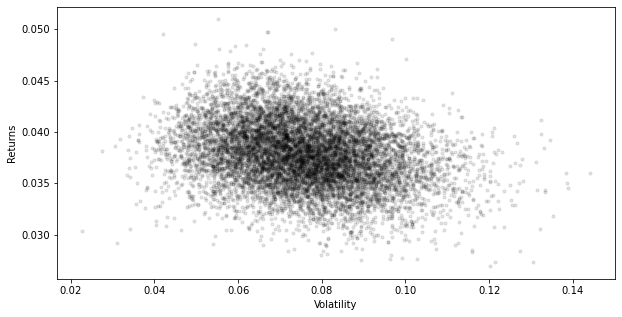

In [351]:
effi = min_var(rets.iloc[:, :3], cova, 10000)
effi.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.1, color = "black", figsize=[10,5]);

# Testing with only stocks real data

In [313]:
from pandas_datareader import data as datareader
df = datareader.DataReader(['AAPL', 'NKE', 'GOOGL', 'AMZN'], 'yahoo', start='2015/01/01', end='2019/12/31')
df = df["Adj Close"]

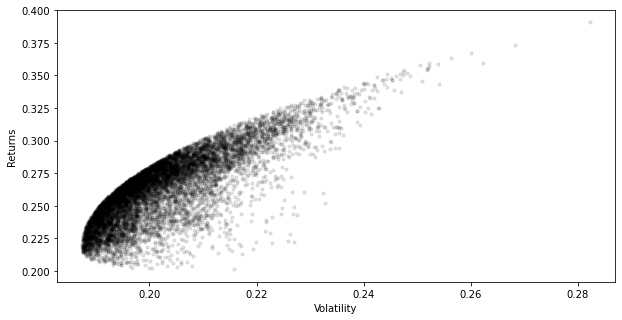

In [366]:
# Returns
rts = df.pct_change()

# Log of percentage change and covariance matrix
cov_matrix = df.pct_change().cov()

# Yearly returns for individual companies
ann_rts = df.pct_change().mean() * 252

# Volatility
ann_sd = df.pct_change().std() * np.sqrt(252)

# Concatenate
assets = pd.concat([ann_rts.reset_index(), ann_sd.reset_index().loc[:, 0]], axis=1)
assets.columns = ["Asset", "Excess_Ret", "STD"]
assets

# Plot
effi_2 = min_var(assets, cov_matrix, 10000)
effi_2.Volatility = effi_2.Volatility * np.sqrt(252)
effi_2.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.1, color = "black", figsize=[10,5]);